In [4]:
from PIL import Image
import os
import numpy as np
import pickle
import torch
import sys
sys.path.append('/workspace/stylegan2-manipulation')
from pivot_tuning_inversion.configs import paths_config, hyperparameters, global_config
os.chdir('/workspace/stylegan2-manipulation')

In [5]:
with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    old_G = pickle.load(f)['G_ema'].cuda()

In [6]:
def load_generator():
    with open('/workspace/stylegan2-manipulation/pivot_tuning_inversion/checkpoints/model_PLPLIHFZUBII_multi_id.pt','rb') as f:
        G = torch.load(f).cuda()
    return G

In [7]:
G = load_generator()

In [8]:
original_dir = '/workspace/stylegan2-manipulation/pivot_tuning_inversion/aligned/'
embedding_dir = '/workspace/stylegan2-manipulation/pivot_tuning_inversion/embeddings/test/e4e/'

In [11]:
image_names = [imgpath.split('.')[0] for imgpath in os.listdir(original_dir)]

In [14]:
imgs = []

In [15]:
for image_name in image_names:
    w = torch.load(embedding_dir+f'{image_name}/0.pt')
    old_image = old_G.synthesis(w, noise_mode='const', force_fp32=True)
    new_image = G.synthesis(w,noise_mode='const',force_fp32=True)
    old_image = (old_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()[0] 
    new_image = (new_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()[0] 
    original_image = Image.open(original_dir+f'{image_name}.jpeg')
    imgs.append(original_image.resize((256,256)))

    imgs.append(Image.fromarray(old_image, 'RGB').resize((256,256)))
    imgs.append(Image.fromarray(new_image, 'RGB').resize((256,256)))

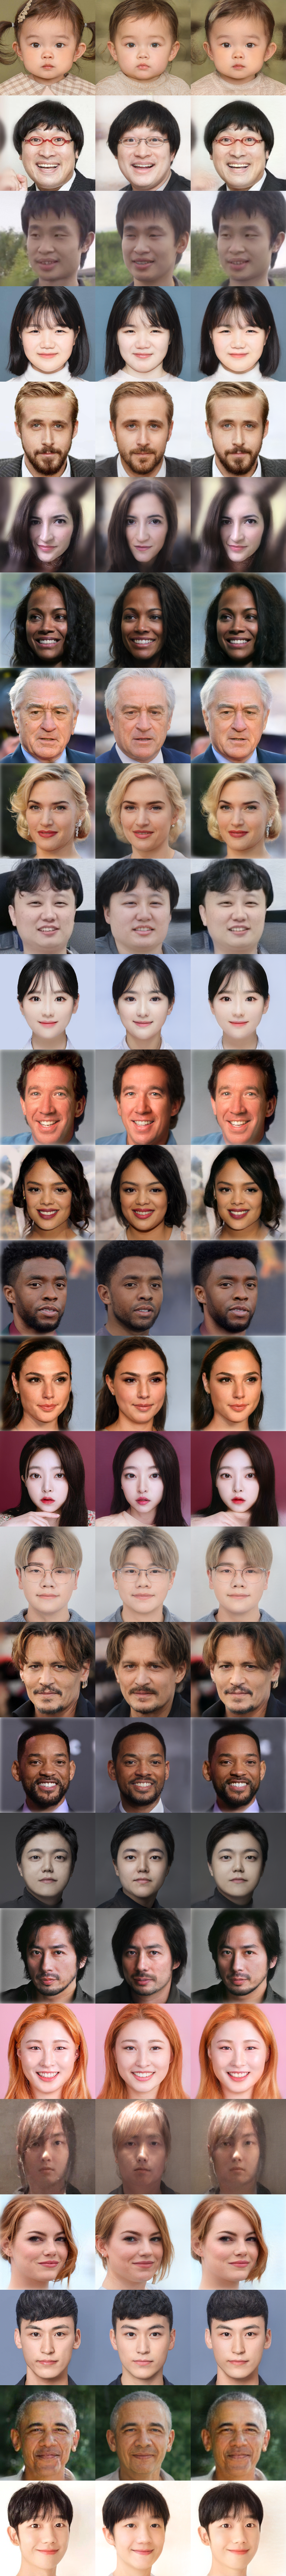

In [16]:
gw, gh = (3, len(image_names))
H, W = (256,256)
result = np.stack(imgs)
result = result.reshape(gh, gw, H, W, 3)
result = result.transpose(0,2,1,3,4)
result = result.reshape(gh * H, gw * W, 3)
display(Image.fromarray(result, 'RGB'))